In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import time
import random
import cv2

from numba import njit, jit
from numba.typed import List
from numba.experimental import jitclass

from utils import build_fragment_from_directory

In [7]:
@njit
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [8]:
start = time.time()
pi = monte_carlo_pi(1000000)
end = time.time()
print(pi)
print(f"Time: {end - start}")  

3.143228
Time: 0.22236919403076172


In [9]:
def monte_carlo_pi_slow(nsamples):
    acc = 0
    for i in range(nsamples):
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [10]:
start = time.time()
pi = monte_carlo_pi_slow(1000000)
end = time.time()
print(pi)
print(f"Time: {end - start}")

3.139584
Time: 1.7662861347198486


In [11]:
spec = [
    ('fragment', nb.float64[:,:,:]),
    ('extended_frag', nb.float64[:, :, :]),
    ('mask', nb.float64[:, :]),
    ('extended_mask', nb.float64[:, :]),
    ('edge_coords', nb.float64[:, :]),
    ('edge_colors', nb.float64[:, :]),
]

@jitclass(spec)
class FragmentJitted:    
    def __init__(
        self,
        fragment,
        extended_frag,
        mask,
        extended_mask,
        edge_coords = None,
        edge_colors = None
    ):
        self.fragment = fragment
        self.extended_frag = extended_frag
        self.mask = mask
        self.extended_mask = extended_mask
        self.edge_coords = edge_coords
        self.edge_colors = edge_colors

In [29]:
data_dir = '../../dataset'
frag = build_fragment_from_directory(data_dir + '/9')
frag2 = build_fragment_from_directory(data_dir + '/11')

In [13]:
# plt.imshow(frag.fragment)
frag.mask.shape

(482, 448)

In [14]:
# jitted_frag = FragmentJitted(frag.fragment.astype('f8'))
# jitted_frag = FragmentJitted(0.0)

In [15]:
jitted_frag = FragmentJitted(
    frag.fragment.astype('f8'), 
    frag.extended_frag.astype('f8'),
    frag.mask.astype('f8'),
    frag.extended_mask.astype('f8'), 
    frag.edge_coords.astype('f8'), 
    frag.edge_colors.astype('f8')
)

In [16]:
# @jit
# def rotate_fragment(frag, angle, c=None):
#     """
#     fast rotate
#     TODO: add edge_coords rotation
#     """
#     # TODO: rotate edge_coords
#     h, w = frag.fragment.shape[:2]
#     if c is None:
#         c = (w // 2, h // 2)
#     m = cv2.getRotationMatrix2D(center=c, angle=angle, scale=1.0)
#     fr = FragmentJitted(
#         cv2.warpAffine(frag.fragment, M=m, dsize=(w, h)).astype('f8'),
#         cv2.warpAffine(frag.extended_frag, M=m, dsize=(w, h)).astype('f8'),
#         (cv2.warpAffine(frag.mask * 255.0, M=m, dsize=(w, h)) == 255).astype('f8'),
#         (cv2.warpAffine(frag.extended_mask * 255.0, M=m, dsize=(w, h)) == 255).astype('f8'),
#         frag.edge_coords,
#         frag.edge_colors
#     )
#     if fr.fragment.max() > 1:
#         fr.fragment = fr.fragment / 255.0
#     if fr.extended_frag.max() > 1:
#         fr.extended_frag = fr.extended_frag / 255.0
#     return fr

In [23]:
from skimage.transform import rotate

@njit
def rotate_fragment(frag, angle):
    # TODO: rotate edge_coords
    return FragmentJitted(
        skimage.transform.rotate(frag.fragment, angle),
        skimage.transform.rotate(frag.extended_frag, angle),
        skimage.transform.rotate(frag.mask, angle),
        skimage.transform.rotate(frag.extended_mask, angle),
        frag.edge_coords,
        frag.edge_colors
    )


In [24]:
rotated_frag = rotate_fragment(jitted_frag, 90)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'skimage' is not defined

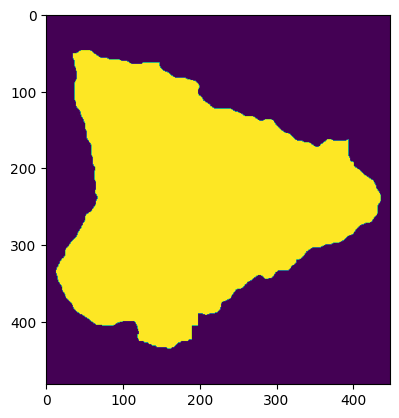

In [81]:
plt.imshow(rotated_frag.mask)

In [31]:
from skimage import draw
from scipy.ndimage import center_of_mass

In [32]:
def check_if_two_fragments_are_too_far(frag1, frag2):
    """
    return True if two frags are too far from each other
    """
    center1 = center_of_mass(frag1.mask)
    center2 = center_of_mass(frag2.mask)
    start = (int(center1[0]), int(center1[1]))
    end = (int(center2[0]), int(center2[1]))
    line = draw.line(*start, *end)
    points = zip(line[0], line[1])
    belong_to_any_frag = [frag1.mask[p[0], p[1]] or frag2.mask[p[0], p[1]] for p in points]
    bad_points_number = len(belong_to_any_frag) - sum(belong_to_any_frag)
    return bad_points_number > 30

In [33]:
def fast_check_if_two_fragments_are_too_far(frag1, frag2):
    """
    return True if two frags are too far from each other
    """
    center1, center2 = center_of_mass(frag1.mask), center_of_mass(frag2.mask)
    start, end = (int(center1[0]), int(center1[1])), (int(center2[0]), int(center2[1]))
    line = draw.line(*start, *end)
    points = zip(line[0], line[1])
    belong_to_any_frag = [frag1.mask[p[0], p[1]] or frag2.mask[p[0], p[1]] for p in points]
    bad_points_number = len(belong_to_any_frag) - sum(belong_to_any_frag)
    return bad_points_number > 30

In [34]:
start = time.time()
for i in range(1000):
    check_if_two_fragments_are_too_far(frag, frag2)
end = time.time()
print(f"Time: {(end - start) / 1000.0}")

Time: 0.002284480333328247


In [35]:
start = time.time()
for i in range(1000):
    fast_check_if_two_fragments_are_too_far(frag, frag2)
end = time.time()
print(f"Time: {(end - start) / 1000.0}")

Time: 0.0022790591716766355
